# Session 7. 지도학습2
## Decision Tree / Support Vector Machine / Random Foreset / XGBoost

#### 퀘스트 기한: 2019. 10. 13 (일) 23:59

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [3]:
df = pd.read_csv('AB_NYC_2019.csv', encoding='utf-8')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


뉴욕의 에어비엔비 데이터셋을 활용하여 방 타입, 숙박 가격, 최소숙박일수, 최근리뷰, 월 리뷰갯수 등으로부터 숙소의 위치를 알아내는 모델

편의상 맨하튼, 브루클린의 숙소들로 범위를 좁혔습니다

In [4]:
our_set = df[df['neighbourhood_group'].isin(['Brooklyn', 'Manhattan'])] ##요 구조!
our_set.shape, df.shape #자료갯수가 얼마나 줄었는지 보여줍니다 (브루클린, 맨하탄으로 한정!)

((41765, 16), (48895, 16))

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

### 전체적인 가격대 분포 살펴보기

Text(0, 0.5, 'Ratio')

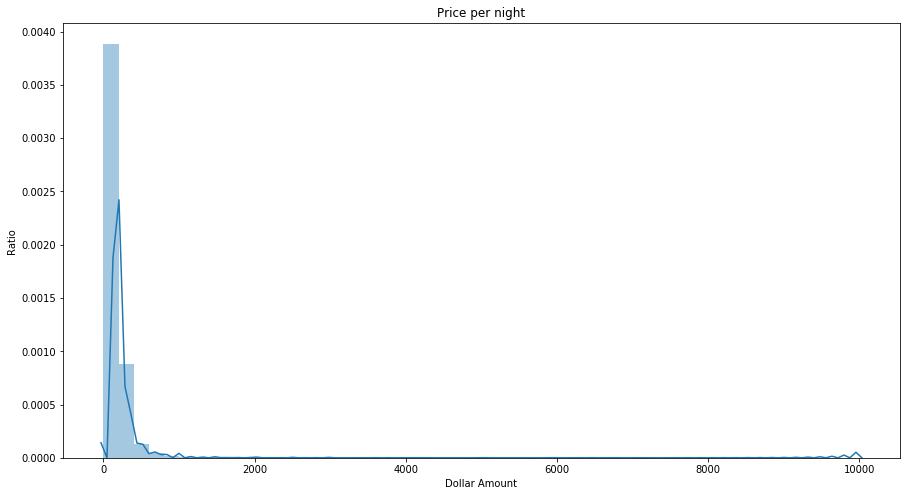

In [6]:
plt.figure(figsize=(15,8))

sns.distplot(our_set['price'])

plt.title("Price per night")
plt.xlabel('Dollar Amount')
plt.ylabel('Ratio')

Text(0, 0.5, 'Ratio')

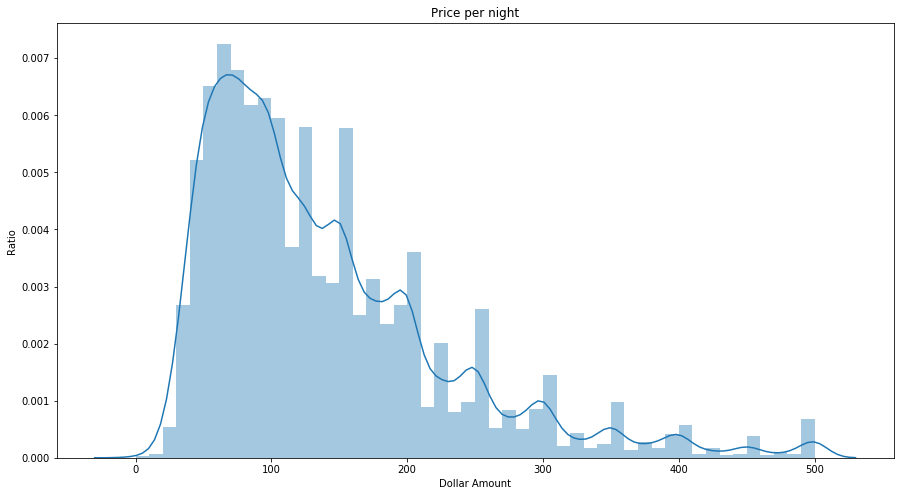

In [7]:
plt.figure(figsize=(15,8))

sns.distplot(our_set[our_set['price']<=500]['price']) 
#위의 그래프에서 가격이 거의 500달러 이하이니 이렇게 설정해서 그래프 자세히 보기

plt.title("Price per night")
plt.xlabel('Dollar Amount')
plt.ylabel('Ratio')

### 방 타입에는 어떤 것들이 있나...

In [8]:
set(our_set['room_type'])

{'Entire home/apt', 'Private room', 'Shared room'}

In [9]:
import random

random_seed = random.randint(0,1000) #0에서 1000까지 난수 생성

### 자연어를 기계가 알아들을 수 있게 수치로 변환

In [10]:
our_set = our_set.replace('Brooklyn', 0).replace('Manhattan', 1)

### 룸 타입 역시 자연어로 되어있으므로, "원핫인코딩"을 통해 수치로 변환

In [11]:
#원핫인코딩 : 초중고대 이렇게 주면 기계가 학습 xx (범주형 data) 
#               초   중   고  대
#그래서 혜민인   0    0   0   1
#       지민인   0    0   1   0 
# 요런식으로!!

x = pd.get_dummies(our_set['room_type']) #이 한줄로 원핫인코딩!
core_cols = our_set[['neighbourhood_group', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']] 
#원래 data+ 원핫인코딩 한 것 붙이기

combined = core_cols.merge(x, left_index=True, right_index=True, how='left').reset_index()
combined.head()

#끝의 3칼럼이 원핫인코딩 진행한 결과!!

,index,neighbourhood_group,price,minimum_nights,number_of_reviews,reviews_per_month,Entire home/apt,Private room,Shared room
0,0,0,149,1,9,0.21,0,1,0
1,1,1,225,1,45,0.38,1,0,0
2,2,1,150,3,0,NaN,0,1,0
3,3,0,89,1,270,4.64,1,0,0
4,4,1,80,10,9,0.10,1,0,0


### 불필요한 컬럼 제거, 결측치 제외

In [12]:
final = combined.drop(columns=['index']).dropna() #na값이 하나라도 있는것 제외
final.shape

(33079, 8)

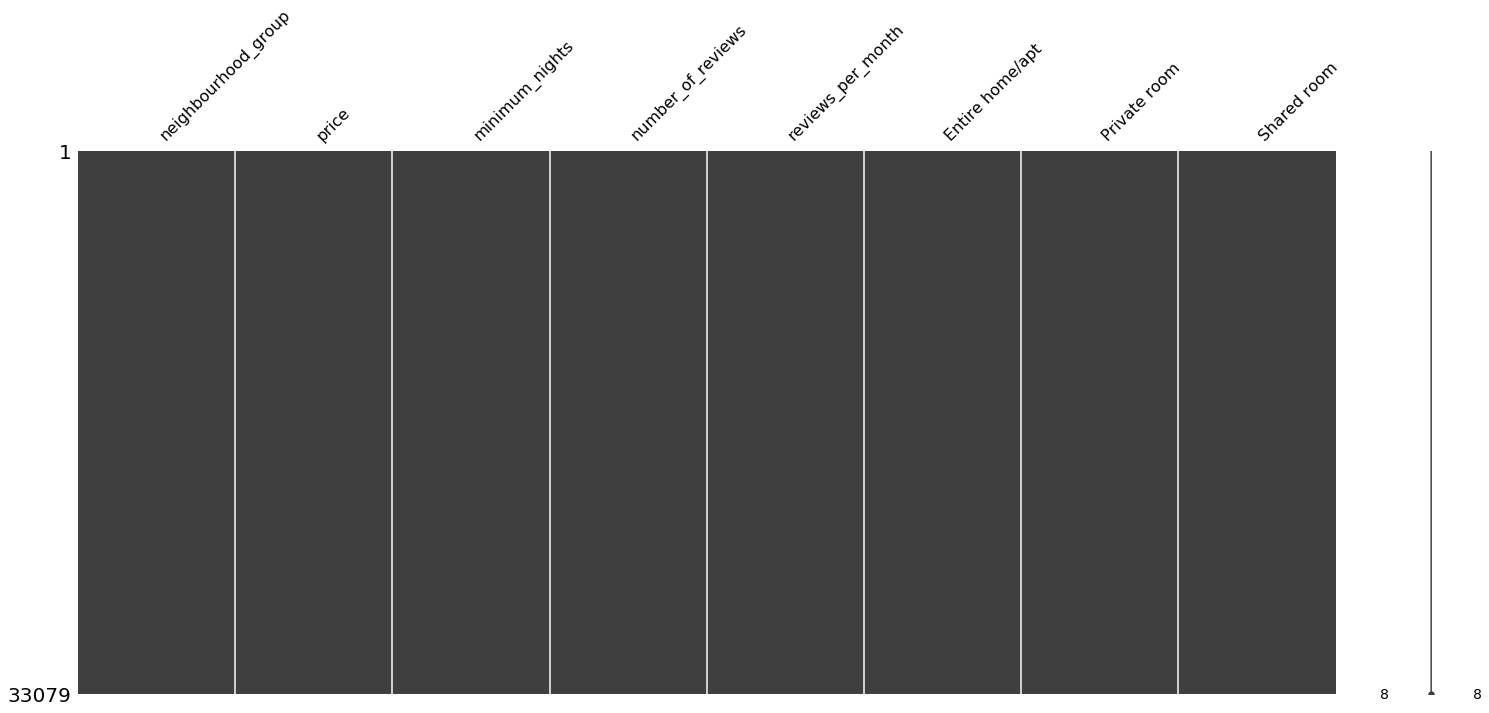

In [13]:
### 혹시 아직 결측치가 남아있는지 최종 점검

import missingno as msno
msno.matrix(final)

In [14]:
final.head()
#결과가 70:30 > 데이터 셋의 분포가 70:30일수 있음 > 즉 데이터 셋의 분포를 신중하게 고려해줘야 이게 그대로 결과에 반영 ㄴㄴ

,neighbourhood_group,price,minimum_nights,number_of_reviews,reviews_per_month,Entire home/apt,Private room,Shared room
0,0,149,1,9,0.21,0,1,0
1,1,225,1,45,0.38,1,0,0
3,0,89,1,270,4.64,1,0,0
4,1,80,10,9,0.10,1,0,0
5,1,200,3,74,0.59,1,0,0


In [15]:
bk = len(final[final['neighbourhood_group']==0])  ##갯수세는 코드~!!!!!!
mh = len(final[final['neighbourhood_group']==1])
tt = len(final)
print("브루클린 건은 {0}건({2:.1f}%), 맨하탄 건은 {1}건({3:.1f}%)이네요.".format(bk, mh, 100*bk/tt, 100*mh/tt))

브루클린 건은 16447건(49.7%), 맨하탄 건은 16632건(50.3%)이네요.


### 본격적인 모델링

In [16]:
### 랜덤 시드를 활용하여 트레인, 테스트셋 분리 / 3:1 비율로

from sklearn.model_selection import train_test_split #y variable은 지역(bk 이냐 mh냐), x는 그 외의 변수들 // 룸타입은 안넣음

X_train, X_test, y_train, y_test = train_test_split(final[['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']], final['neighbourhood_group'], 
                                                    test_size=0.25, random_state=random_seed) #위에서 randomseed만들어둔것

In [17]:
### 랜덤포레스트 모델 수립, 대충 하이퍼 파라미터 제공
import time
from sklearn.ensemble import RandomForestClassifier #분류문제니까 소환

random_seed = random.randint(0,1000)
rf = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=random_seed)
# n_estimators :나무를 200그루 만들겠다


### 학습 진행
t0 = time.time()
rf.fit(X_train, y_train)
elapsed = time.time()-t0
print("걸린시간은 {:.2f}초입니다.".format(elapsed))

걸린시간은 22.45초입니다.


In [18]:
from sklearn.metrics import accuracy_score

### 학습된 모델로 분류 예측 : 모델이 가져온 것 
prediction = rf.predict(X_test)


### 채점 : 원래 있던 data - 정답
accuracy = accuracy_score(y_test, prediction)


### 성적 발표
print(f'Mean accuracy score: {100*accuracy:.3}%')

Mean accuracy score: 61.7%


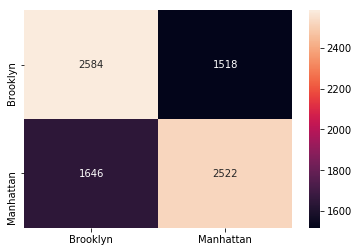

In [19]:
### 오답/정답 시각화를 위한 간단한 히트맵
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(y_test, prediction), columns=['Brooklyn', 'Manhattan'], index=['Brooklyn', 'Manhattan'])

sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
#특성 중요도 보고 싶어서 추가해본다

In [ ]:
!!!!!!질문 1 

In [23]:
#from sklearn.datasets import load_iris
print(rf.feature_importances_)
#이거 특성 이름이랑 같이 출력하고 싶으면어떻게 하징?!
# 보통 몇 이상이어야 중요하다?!

[0.32520526 0.10530809 0.2302268  0.33925985]


In [ ]:
모델링 참고사항 : XGBOOST

In [ ]:
from xgboost import XGBClassifier

clf = XGBClassifier()
clf.fit(X_train, y_train)

In [ ]:
prediction2 = clf.predict(X_test)
accuracy2 = accuracy_score(y_test, prediction2)
print('정확도 : {:.3f}%'.format(100*accuracy2))

# ★퀘스트★

### 오늘 배운 모델들을 활용하여 (DT, SVM, XGBOOST / RF는 제외!!) 이보다 더 정교한 모델을 만들어보아요.
### 목표는 정확도 > 60%

(+추가)
같은 모델이더라도, 하이퍼 파라미터를 바꿔가며 코드를 실행해보면 결과가 달라집니다. 

time 모듈을 활용하여 각 모델별로 걸리는 시간도 측정해보아요.

생각보다 높은 정확도를 기록하였다면, 캐글에도 한번 등록해보아요. (https://kaggle.com)

모르는 게 있으면 질문도 좋습니다.

In [ ]:
!!!!질문 2

In [ ]:
#하이퍼 파라미터 > 18번의 n.estimate!
최적 하이퍼 파라미터 구하는 법?!!!!

In [ ]:
adaboost사용

In [24]:
from sklearn.model_selection import train_test_split
#from sklearn.datasets import make_moons

X_train, X_test, y_train, y_test = train_test_split(final[['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']], final['neighbourhood_group'], 
                                                    test_size=0.25, random_state=random_seed)

In [27]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

In [28]:
from sklearn.metrics import accuracy_score

# 학습된 모델로 분류 예측 : 모델이 가져온 것 
prediction = ada_clf.predict(X_test)


# 채점 : 원래 있던 data - 정답
accuracy = accuracy_score(y_test, prediction)


# 성적 발표
print(f'Mean accuracy score: {100*accuracy:.3}%')

Mean accuracy score: 62.4%


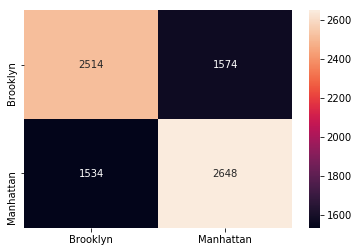

In [30]:
### 오답/정답 시각화를 위한 간단한 히트맵
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(y_test, prediction), columns=['Brooklyn', 'Manhattan'], index=['Brooklyn', 'Manhattan'])

sns.heatmap(cm, annot=True, fmt='d')